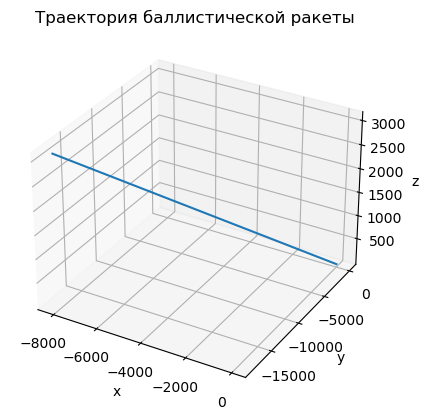

In [18]:
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import math
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
# -----------------------------------------------------------------------------------------------
# начальные значения
v0 = 2000                               # начальная скорость БЦ, м/с
theta = 30
phi = 20
# -----------------------------------------------------------------------------------------------
# константы
a = 6378245                             # большая полуось Земли
GM = 3.986004418e14                     # произведение гравитационной постоянной Земли на массу
c_0 = 2.202095e10                       # коэффициент гравитационного поля Земли
omega = 7.292115e-5                     # угловая скорость вращения Земли
f = 298.3                               # коэффициент сжатия Земли
e_squared = (2*f-1)/((f - 1)**2)        # квадрат эксцентриситета Земли
# -----------------------------------------------------------------------------------------------

def derivatives(t, state):
    x, y, z, vx, vy, vz = state
    # вычисление производных 
    dx_dt = vx
    dy_dt = vy
    dz_dt = vz
    # учет ускорения свободного падения g_0
    r_0 = math.sqrt(x**2 + y**2 + z**2)
    A = GM/r_0**3
    B = (3*c_0)/r_0**2
    C = (15*c_0)/r_0**4
    D = (6*c_0)/r_0**2
    
    dvx_dt = -A*x + A*B*x - A*C*x*z**2
    dvy_dt = -A*y + A*B*y - A*B*y*z**2
    dvz_dt = -A*z + A*B*z - D*z + C*z**3
    
    # учет центростремительного ускорения БЦ
    dvx_dt += omega**2 * x
    dvy_dt += omega**2 * y
    dvz_dt += 0
    
    # учет кориолисова ускорения
    dvx_dt += 2 * omega * dy_dt
    dvy_dt += -2 * omega * dx_dt
    dvz_dt += 0
    
    # учет аэродинамического ускорения 
    v = np.sqrt(vx**2 + vy**2 + vz**2)
    # тк в задании не даны начальная масса БЦ, и другие данные, чтобы посчитать баллистический коэффициент, я приму gamma = 0,347 (нашла значения для пули)
    gamma = 0.347 # для более точных расчетов нужно в процессе полета пересчитывать это значение (но тк начальных параметров нет, здесь я этого не делаю)
    s = z/r_0                                       # синус широты цели
    h = r_0 - a/(math.sqrt(1 + e_squared * s**2))   # высота БЦ над поверхностью Земли
    rho = 10**(-1.8977 * 10**-29 * h**6 + 8.7419 * 10**-24 * h**5 - 1.4909 * 10**-18 * h**4 + 1.1591 * 10**(-13) * h**3 - 4.0740 * 10**(-9) * h**2 - 8.0463 * 10**(-6) * h + 2.0667 * 10**(-2))
    E = (-gamma * rho * v)/2
    
    dvx_dt = E * dx_dt
    dvy_dt = E * dy_dt
    dvz_dt = E * dz_dt
    
    return np.array([dx_dt, dy_dt, dz_dt, dvx_dt, dvy_dt, dvz_dt])
# -------------------------------------------------------------------------------------
# метод Рунге-Кутта 4 порядка
# def runge_kutta_4(u_0, n):
    # tau = (t_e - t_s) / n   # возможно лишнее
    # u_n = u_0
    # t_n = t_s
    # u_tr = [u_0]
    # x_tr = [x_0]
    # y_tr = [y_0]
    # z_tr = [z_0]
    
    # for i in range(1, n):
    #     t_n = t_s + tau
    #     # значения коэффициентов в явном виде
    #     k1 = g(t_n, u_n)
    #     k2 = g(t_n + 0.5 * tau, u_n + 0.5 * tau * k1)
    #     k3 = g(t_n + 0.5 * tau, u_n + 0.5 * tau * k2)
    #     k4 = g(t_n + 0.5 * tau, u_n + tau * k3)
        
    #     # q1 = u_n
    #     # Next iteration
    #     u_n = u_n + tau / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    #     u_tr.append(u_n)
    #     x_tr.append(u_n[0])
    #     y_tr.append(u_n[1]) 
    #     z_tr.append(u_n[2]) 
        
    # return u_tr, x_tr, y_tr, z_tr
    
def runge_kutta_4(t0, t_end, dt, initial_state):
    t = t0
    states = [initial_state]
    
    while t < t_end:
        state = states[-1]
        k1 = dt * derivatives(t, state)
        k2 = dt * derivatives(t + dt/2, state + k1/2)
        k3 = dt * derivatives(t + dt/2, state + k2/2)
        k4 = dt * derivatives(t + dt, state + k3)
        
        new_state = state + (k1 + 2*k2 + 2*k3 + k4)/6
        states.append(new_state)
        
        t += dt
    
    return np.array(states)

def main():
    t0 = 0
    t_end = 10
    dt = 0.1
    initial_state = np.array([1, 1, 1, v0 * np.sin(theta) * np.cos(phi), v0 * np.sin(theta) * np.sin(phi), v0 * np.cos(theta)])
    result = runge_kutta_4(t0, t_end, dt, initial_state)

    # извлечение координат и времени из результата
    x = result[:, 0]
    y = result[:, 1]
    z = result[:, 2]
    vx = result[:, 3]
    vy = result[:, 4]
    vz = result[:, 5]
    t = np.arange(t0, t_end + dt, dt)
    
    return [x, y, z, vx, vy, vz, t] 

result = main()
result_data = pd.DataFrame()
result_data['x'] = result[0]
result_data['y'] = result[1]
result_data['z'] = result[2]
# result_data['t'] = result[6]

result_data
# вычисление высоты, скорости и ускорения
x = result[0]
y = result[1]
z = result[2]
vx = result[3]
vy = result[4]
vz = result[5]

v = np.sqrt(vx**2 + vy**2 + vz**2)

# # Визуализация высоты от времени
# plt.figure()
# plt.plot(t, h)
# plt.xlabel('Время')
# plt.ylabel('Высота')
# plt.title('Высота от времени')
# plt.grid(True)

# # Визуализация высоты от дальности
# plt.figure()
# plt.plot(x, h)
# plt.xlabel('Дальность')
# plt.ylabel('Высота')
# plt.title('Высота от дальности')
# plt.grid(True)

# # Визуализация скорости от времени
# plt.figure()
# plt.plot(t, v)
# plt.xlabel('Время')
# plt.ylabel('Скорость')
# plt.title('Скорость от времени')
# plt.grid(True)

# # Визуализация скорости от дальности
# plt.figure()
# plt.plot(x, v)
# plt.xlabel('Дальность')
# plt.ylabel('Скорость')
# plt.title('Скорость от дальности')
# plt.grid(True)

# # Визуализация ускорения от времени
# plt.figure()
# plt.plot(t, a)
# plt.xlabel('Время')
# plt.ylabel('Ускорение')
# plt.title('Ускорение от времени')
# plt.grid(True)

# # Визуализация ускорения от дальности
# plt.figure()
# plt.plot(x, a)
# plt.xlabel('Дальность')
# plt.ylabel('Ускорение')
# plt.title('Ускорение от дальности')
# plt.grid(True)

# Визуализация траектории ракеты в 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Траектория баллистической ракеты')

plt.show()
    